In [69]:
import cmdstanpy
cmdstanpy.install_cmdstan() # this is key for running stan models
import os
from cmdstanpy import CmdStanModel
import pandas as pd
import plotnine as pn
import numpy as np

CmdStan install directory: /Users/emmett/.cmdstan
CmdStan version 2.35.0 already installed
Test model compilation


Importing CmdStanPy lets you install Cmdstan which lets you run the stan models

In [70]:
penguins_url = "https://raw.githubusercontent.com/roualdes/data/refs/heads/master/penguins.csv"
df = pd.read_csv(penguins_url)

In [71]:
df_clean = df[["bill_length_mm", "bill_depth_mm"]].dropna()

Dropping all data with NaN so the data fits the Stan model

In [72]:
df_clean.head()

,bill_length_mm,bill_depth_mm
0,39.1,18.7
1,39.5,17.4
2,40.3,18.0
4,36.7,19.3
5,39.3,20.6


In [73]:
x = df_clean["bill_length_mm"].values
y = df_clean["bill_depth_mm"].values
N = df_clean.shape[0]
stan_linedat = {
    "x": x,
    "y": y,
    "N": N
}

This makes it so we can put our data into the Stan model which takes the inputs x, y and N

In [74]:
stan_reg = os.path.join('linear_reg.stan')

This opens the Stan linear regression model we made earlier in the .stan file

In [75]:
model = CmdStanModel(stan_file=stan_reg)

16:34:53 - cmdstanpy - INFO - compiling stan file /Users/emmett/Desktop/math385/linear_reg.stan to exe file /Users/emmett/Desktop/math385/linear_reg
16:34:56 - cmdstanpy - INFO - compiled model executable: /Users/emmett/Desktop/math385/linear_reg


CmdStanModel instantiates a CmndStanModel class which allows us to call on the stan model

In [76]:
fit2 = model.sample(data=stan_linedat)

16:34:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:34:57 - cmdstanpy - INFO - CmdStan done processing.


Fit2 fits the data we prepared to the Stan linear regression model

In [77]:
fit2.stan_variable('alpha')

array([21.8683, 21.7753, 22.0757, ..., 20.8435, 21.2265, 20.1713])

In [78]:
fit2.stan_variable('beta')

array([-0.10635  , -0.109198 , -0.115829 , ..., -0.0861358, -0.0939851,
       -0.0685531])

Shows how stan_variable returns numpy array

In [79]:
alpha = fit2.stan_variable('alpha').mean() # is the intercept of regression line
beta = fit2.stan_variable('beta').mean() # is the slope of regression
alpha, beta

(np.float64(20.865758699999997), np.float64(-0.084641877225))

Here we use stan_variable to return a numpy array then take the mean of alpha and beta 

In [80]:
alpha_df = pd.DataFrame({'alpha': fit2.stan_variable('alpha')})
beta_df = pd.DataFrame({'beta': fit2.stan_variable('beta')})

These 2 data frames allow us to plot the density of alpha and beta

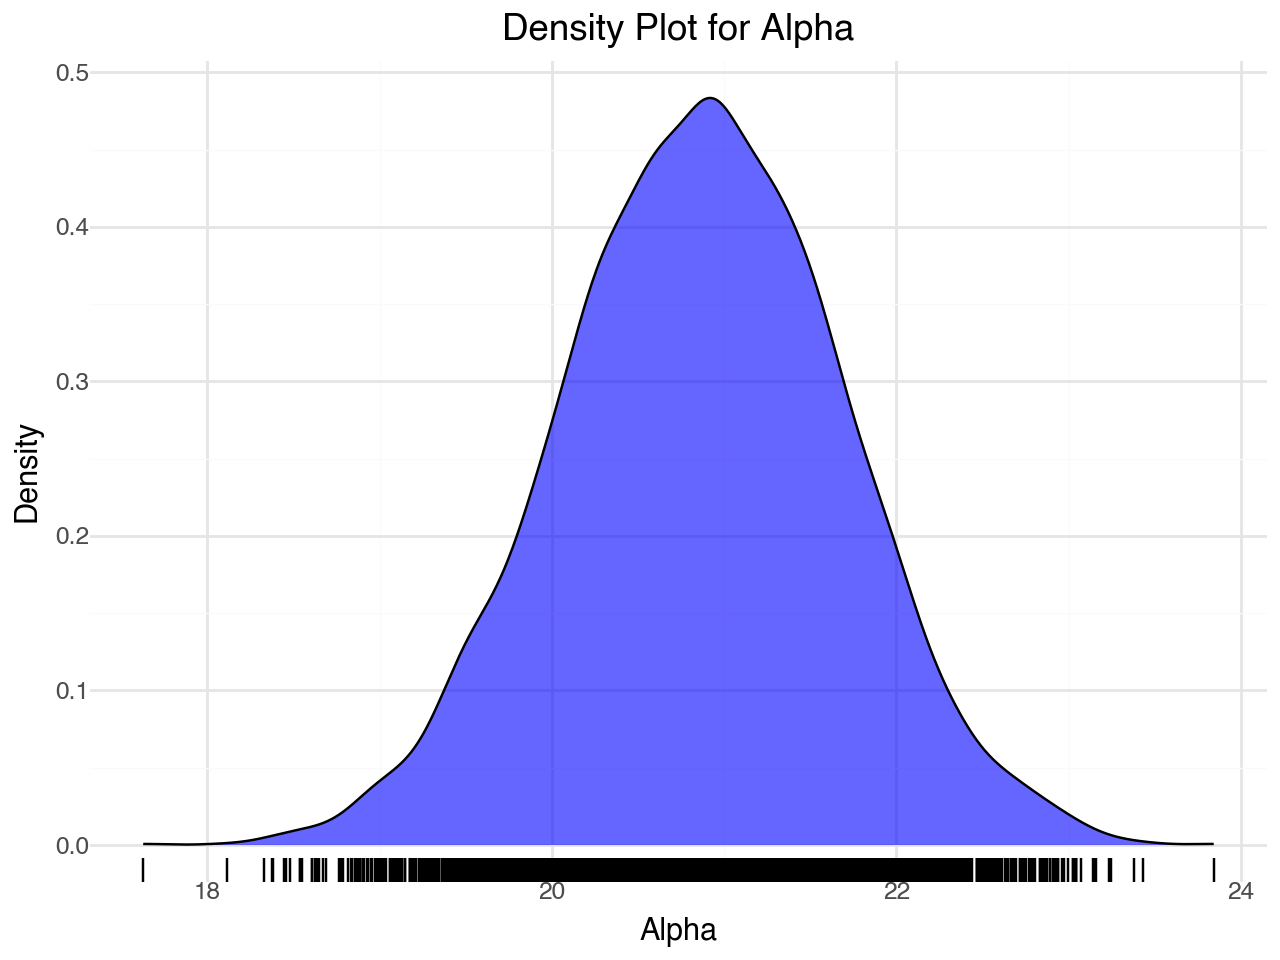

In [81]:
pn.ggplot(alpha_df, pn.aes(x='alpha')) + \
    pn.geom_density(fill="blue", alpha=0.6) + \
    pn.geom_rug(alpha_df) + \
    pn.labs(
        title="Density Plot for Alpha",
        x="Alpha",
        y="Density"
    ) + \
    pn.theme_minimal()

The density plot for alpha shows the probability for a value of the intercept based on all the data points. The rug plot represents every alpha generated by the Stan model.

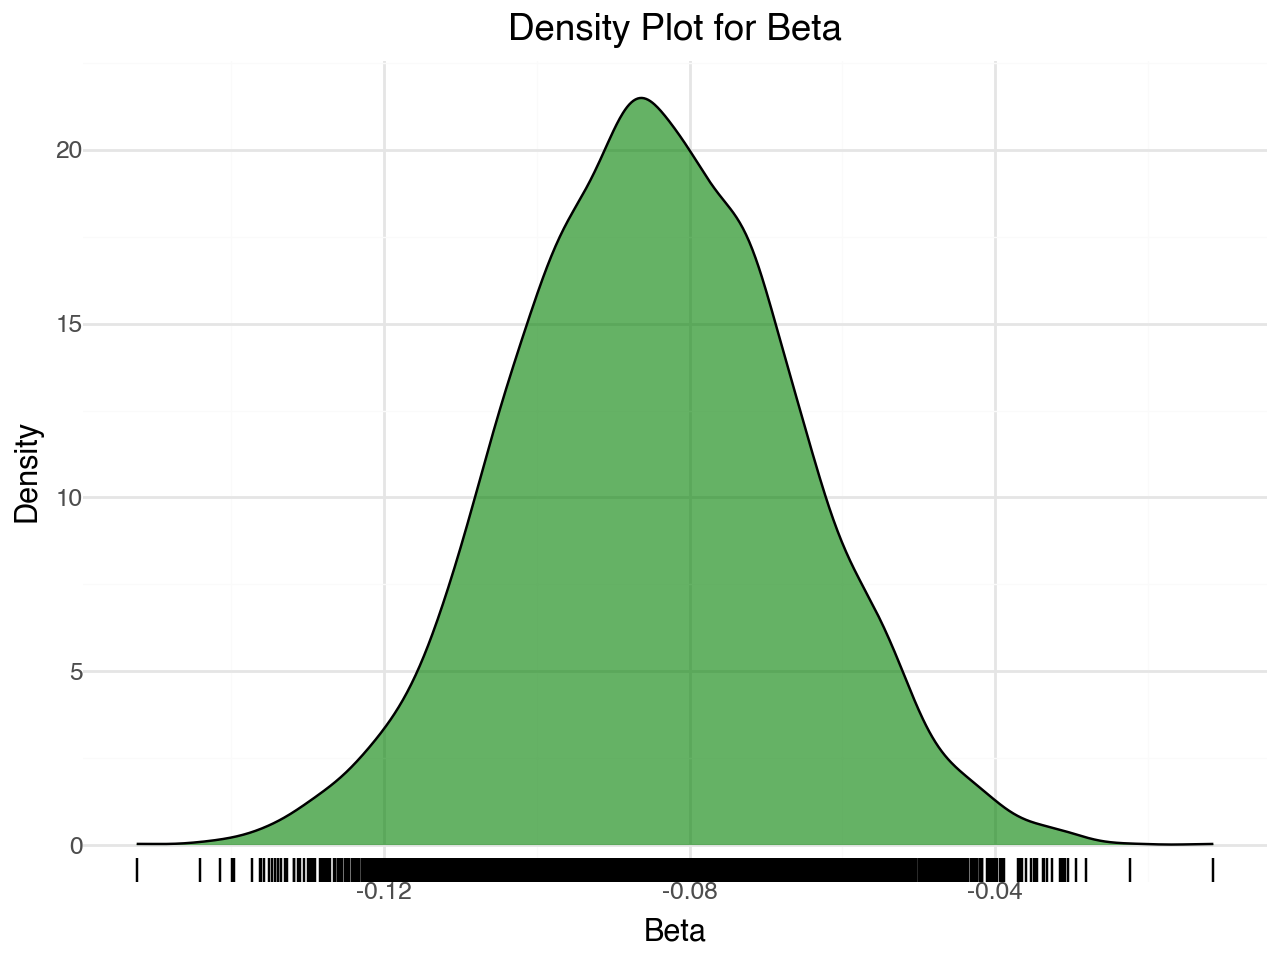

In [82]:
pn.ggplot(beta_df, pn.aes(x='beta')) + \
    pn.geom_density(fill="green", alpha=0.6) + \
    pn.geom_rug(beta_df) + \
    pn.labs(
        title="Density Plot for Beta",
        x="Beta",
        y="Density"
    ) + \
    pn.theme_minimal()

The density plot for beta represents the probability for a value of the slope based on all the data. The rug model again shows all the betas generated by Stan.

In [83]:
x_value = np.linspace(df_clean["bill_length_mm"].min(), df_clean["bill_length_mm"].max(), num=100)
alpha_values = fit2.stan_variable('alpha')
beta_values = fit2.stan_variable('beta')
y_value = alpha_values + beta_values * x_value[:, None]

This block creates a 2D array with every x value having an (a,b) pair

In [84]:
x_repeat = np.repeat(x_value, alpha_values.size) # repeats each x value for every (a,b) pair
y_flatten = y_value.flatten()

This block turns the 2D array 'y_value' back into a 1D array so you can put it into a data frame

In [85]:
lines_df = pd.DataFrame({
    "x1": x_repeat,
    "y1": y_flatten,
    "group": np.repeat(range(alpha_values.size), x_value.size)
})

This block creates a data frame to graph the line of regression for each (a,b) pair, this will allow us to plot a regression line for each point.

In [89]:
x_values = np.linspace(df_clean["bill_length_mm"].min(), df_clean["bill_length_mm"].max())
y_values = alpha + beta * x_values

These values are used to plot the regession line

In [87]:
regression_df = pd.DataFrame({ # Creates a data frame of the data for the regression line
    "x": x_values,
    "y": y_values
})
data_points = pd.DataFrame({ # Data frame original bill measurment data
    "x2": df_clean["bill_length_mm"],
    "y2": df_clean["bill_depth_mm"]
})

This block creates dataframes for the x and y values so we can pass it through plotnine

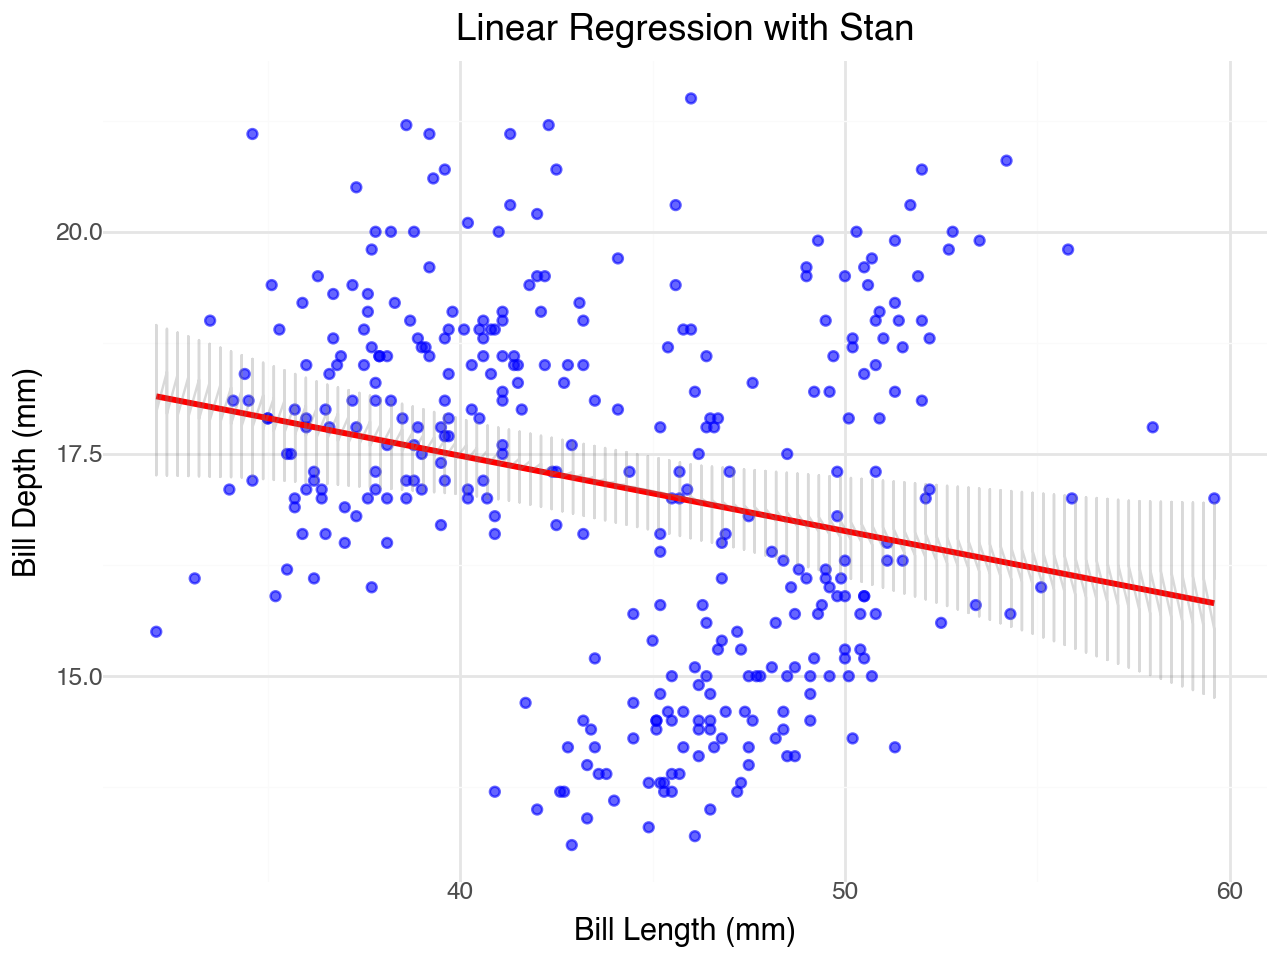

In [88]:
pn.ggplot(data=data_points) + \
    pn.geom_point(pn.aes(x="x2", y="y2"), color="blue", alpha=0.6) + \
    pn.geom_line(pn.aes(x="x", y="y"), data=regression_df, color="red", size=1.2) + \
    pn.geom_line(data=lines_df, mapping=pn.aes(x="x1", y="y1", group="alpha"), color="grey", alpha=0.3) + \
    pn.labs(
        x="Bill Length (mm)",
        y="Bill Depth (mm)",
        title="Linear Regression with Stan"
    ) + \
    pn.theme_minimal()